<a href="https://colab.research.google.com/github/RewinaB/Deep-Learning-Projects/blob/main/prehire_retention_survival_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Survival Analysis for Pre-Hire Retention

In [1]:
!pip install lifelines


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 12.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=7962998056024997d45be06315890e6c4a71968bac001fe2f45222ccbb07d7c0
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [2]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt


## Load the full simulated dataset with ATS features

In [3]:
data = pd.read_csv("/content/simulated_retention_data_extended.csv")
data.head()


,job_hops,interview_score,salary_alignment,remote_preference,commute_distance,tenure_months,event,education_level,job_level,industry_experience_years
0,4,3.049373,1,1,16.571917,6.329659,1,phd,mid,2
1,1,2.934827,1,1,14.989581,21.976158,0,bachelor,senior,14
2,3,3.250239,1,1,17.072709,5.810846,1,phd,entry,3
3,3,2.473371,0,0,11.138480,10.180004,1,bachelor,mid,14
4,1,2.824659,1,1,7.821906,10.634067,1,bachelor,senior,8


## One-hot Encode Categorical Features

In [4]:
data_encoded = pd.get_dummies(data, columns=["education_level", "job_level"], drop_first=True)
data_encoded.head()


,job_hops,interview_score,salary_alignment,remote_preference,commute_distance,tenure_months,event,industry_experience_years,education_level_high_school,education_level_master,education_level_phd,job_level_mid,job_level_senior
0,4,3.049373,1,1,16.571917,6.329659,1,2,False,False,True,True,False
1,1,2.934827,1,1,14.989581,21.976158,0,14,False,False,False,False,True
2,3,3.250239,1,1,17.072709,5.810846,1,3,False,False,True,False,False
3,3,2.473371,0,0,11.138480,10.180004,1,14,False,False,False,True,False
4,1,2.824659,1,1,7.821906,10.634067,1,8,False,False,False,False,True


## Fit Cox Proportional Hazards Model and Evaluate

 The model estimates hazard ratios. which tell us how a feature influences the risk of attrition.

* A hazard ratio > 1 means higher risk of leaving

* A hazard ratio < 1 means lower risk (more likely to stay)

In [5]:
cph = CoxPHFitter()
cph.fit(data_encoded, duration_col="tenure_months", event_col="event")
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 300 total observations, 81 right-censored observations>
             duration col = 'tenure_months'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 300
number of events observed = 219
   partial log-likelihood = -1021.64
         time fit was run = 2025-07-02 13:19:57 UTC

---
                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                    
job_hops                     0.00      1.00      0.05           -0.10            0.10                0.91                1.10
interview_score              0.06      1.07      0.15           -0.23            0.35                0.80                1.43
salary_alignment             0.14      1.15      0.14           -0.14            0.42                0.87                1.52
remote_preference            0.17      1.18      0.14           -0.11            0.44                0.90                1.55
commute_distance            -0.01      0.99      0.01           -0.03            0.02                0.97                1.02
industry_experience_years    0.01      1.01      0.02           -0.02            0.04                0.98                1.05
education_level_high_school -0.10      0.90      0.19           -0.47            0.26                0.63                1.30
education_level_master      -0.30      0.74      0.20           -0.70            0.09                0.50                1.10
education_level_phd         -0.27      0.76      0.20           -0.66            0.13                0.51                1.13
job_level_mid                0.19      1.22      0.17           -0.15            0.54                0.86                1.71
job_level_senior             0.04      1.04      0.17           -0.29            0.37                0.74                1.45

                             cmp to     z    p  -log2(p)
covariate                                               
job_hops                       0.00  0.03 0.98      0.03
interview_score                0.00  0.44 0.66      0.59
salary_alignment               0.00  0.99 0.32      1.63
remote_preference              0.00  1.19 0.23      2.10
commute_distance               0.00 -0.41 0.68      0.55
industry_experience_years      0.00  0.83 0.41      1.30
education_level_high_school    0.00 -0.56 0.58      0.79
education_level_master         0.00 -1.50 0.13      2.90
education_level_phd            0.00 -1.34 0.18      2.46
job_level_mid                  0.00  1.11 0.27      1.91
job_level_senior               0.00  0.23 0.82      0.29
---
Concordance = 0.55
Partial AIC = 2065.28
log-likelihood ratio test = 9.17 on 11 df
-log2(p) of ll-ratio test = 0.72

In [6]:
c_index = concordance_index(data_encoded['tenure_months'], -cph.predict_partial_hazard(data_encoded), data_encoded['event'])
print(f"Concordance Index: {c_index:.4f}")


Concordance Index: 0.5514


This is the primary evaluation metric for survival models. It measures ranking accuracy — how well the model orders people by risk.

1.0 = perfect risk ranking

0.5 = random chance

0.55 = slightly better than chance

My result (0.5514) suggests the model has some weak predictive value, but it may benefit from:

Feature engineering

More data

Adding behavioral/interview/screening variables

## Stratified Survival Curves by Job Level

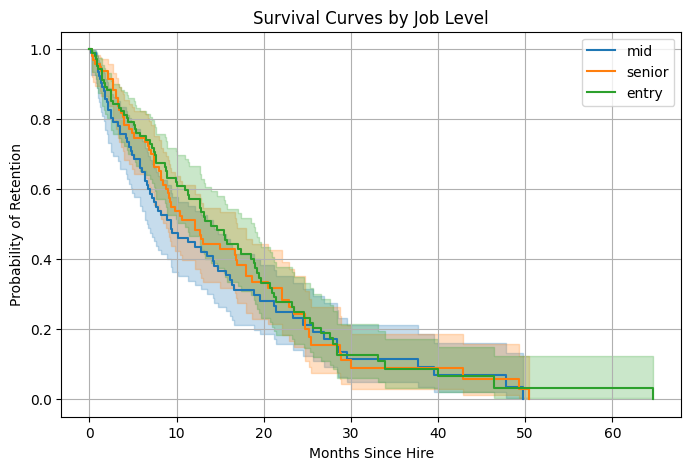

In [7]:
kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 5))
for level in data["job_level"].unique():
    mask = data["job_level"] == level
    kmf.fit(data.loc[mask, "tenure_months"], data.loc[mask, "event"], label=level)
    kmf.plot_survival_function()

plt.title("Survival Curves by Job Level")
plt.xlabel("Months Since Hire")
plt.ylabel("Probability of Retention")
plt.grid()
plt.show()


All curves show a monotonic decrease, which is expected — over time, the probability of still being employed declines.

2. Entry-Level (Green) Has Slightly Higher Retention Initially
From 0–10 months, the green line (entry) appears slightly higher than the others. This may indicate that:

Entry-level employees are less likely to churn early, possibly due to onboarding programs or fewer options.

3. Mid-Level (Blue) Declines Faster at Midpoints
The mid-level line dips a bit more steeply around the 10–25 month range, suggesting:

Mid-level employees may churn earlier, possibly due to mismatches in expectations or lack of growth opportunities.

4. Senior-Level (Orange) Tracks Closely but Slightly Better Than Mid-Level
Senior employees appear to have slightly better retention than mid, especially after 15 months. This might reflect:

More stable career trajectories

Higher investment in the hiring process

Better compensation/alignment

5. Confidence Intervals Overlap Heavily
The shaded areas overlap quite a bit → this means differences may not be statistically significant. You’d want to run a log-rank test to formally test group differences.

In [10]:
from lifelines.statistics import logrank_test

# Filter survival data for pairwise comparisons
entry = data[data["job_level"] == "entry"]
mid = data[data["job_level"] == "mid"]
senior = data[data["job_level"] == "senior"]

# Log-rank test: Entry vs Mid
result_entry_vs_mid = logrank_test(
    entry['tenure_months'], mid['tenure_months'],
    event_observed_A=entry['event'], event_observed_B=mid['event']
)
print("Entry vs Mid")
print(result_entry_vs_mid.summary)

# Log-rank test: Entry vs Senior
result_entry_vs_senior = logrank_test(
    entry['tenure_months'], senior['tenure_months'],
    event_observed_A=entry['event'], event_observed_B=senior['event']
)
print("\nEntry vs Senior")
print(result_entry_vs_senior.summary)

# Log-rank test: Mid vs Senior
result_mid_vs_senior = logrank_test(
    mid['tenure_months'], senior['tenure_months'],
    event_observed_A=mid['event'], event_observed_B=senior['event']
)
print("\nMid vs Senior")
print(result_mid_vs_senior.summary)


Entry vs Mid
   test_statistic         p  -log2(p)
0        1.073206  0.300222  1.735896

Entry vs Senior
   test_statistic         p  -log2(p)
0        0.229025  0.632247  0.661439

Mid vs Senior
   test_statistic         p  -log2(p)
0        0.723967  0.394846  1.340639


none of it is significant

## Export Predicted Survival Risk Scores

In [8]:
# Higher score = higher risk of leaving
data_encoded["survival_risk_score"] = cph.predict_partial_hazard(data_encoded)
data_encoded[["survival_risk_score"]].head()


,survival_risk_score
0,1.110604
1,1.456537
2,0.934499
3,1.246823
4,1.391717


In [9]:
data_encoded.to_csv("predicted_risk_scores.csv", index=False)
print("Exported with risk scores.")



Exported with risk scores.


Higher score = higher likelihood of leaving early

These can be used downstream for:

Risk-based interview follow-up

Personalized onboarding

Early warning systems in HR analytics